In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import pprint
import warnings
from pandas.errors import ParserWarning

pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)

import re
import os
from pathlib import Path
import warnings
from typing import List, Dict, Tuple, Any, Union, Callable
from astropy.table import Table, MaskedColumn

from astroquery import mast
from astroquery.mast import Observations
from astropy.time import Time, TimeJD, TimeDelta
from astroquery.mast.missions import MastMissions

hst_mission = MastMissions(mission='hst')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 300

from tqdm import tqdm

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

In [27]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np

from taurex.binning.fluxbinner import FluxBinner
from taurex.util.util import wnwidth_to_wlwidth

import taurex
import os
from taurex.log import disableLogging

disableLogging()
from taurex.cache import OpacityCache, CIACache
from taurex.data.profiles.temperature import Isothermal, NPoint
from taurex.data import Planet
from taurex.data.stellar import BlackbodyStar
from taurex.data.profiles.chemistry import TaurexChemistry
from taurex.data.profiles.chemistry import ConstantGas
from taurex.data.profiles.chemistry import TwoLayerGas
from taurex.model import TransmissionModel, EmissionModel
from taurex.contributions import *
from taurex.data.spectrum.observed import ObservedSpectrum
from astropy.io.fits.verify import VerifyWarning
import warnings

warnings.simplefilter('ignore', category=VerifyWarning)
import gzip

In [44]:
# local setup
WDIR = Path().cwd().parent

CLEAN_TRANSMISSION_PATH = WDIR / "data/transitspec_with_spectral_elements.csv"
TAUREX_LIGHTCURVE_PATH = WDIR / "data/taurex_lightcurves_LW"

LINELISTS_PATH = str(WDIR / "data/Linelists/xsec/TauRex_sampled_xsecs_R10000_0.3-15")
CIA_PATH = str(WDIR / "data/Linelists/cia/hitran")

LINELISTS_PATH = WDIR / "data/Linelists/xsec/TauRex_sampled_xsecs_R10000_0.3-15"
CIA_PATH = WDIR / "data/Linelists/cia/hitran"

In [49]:
def create_spec(args):
    OpacityCache().set_opacity_path(LINELISTS_PATH)
    CIACache().set_cia_path(CIA_PATH)

    isothermal = Isothermal(T=args['target_data']['planet_temperature'])

    planet = Planet(planet_radius=args['target_data']['planet_radius_jup'],
                    planet_mass=args['target_data']['planet_mass_jup'])

    star = BlackbodyStar(temperature=args['target_data']['star_temperature'],
                         radius=args['target_data']['star_radius'],
                         mass=args['target_data']['star_mass']
                         )

    chemistry = TaurexChemistry(fill_gases=['H2', 'He'], ratio=0.17)

    chemistry.addGas(TwoLayerGas('H', mix_ratio_surface=1e-2,
                                 mix_ratio_top=0.5, mix_ratio_P=1e4))  #only important if using H-

    for ii in range(len(args['molecules'])):
        chemistry.addGas(ConstantGas(args['molecules'][ii], mix_ratio=args['abundances'][ii]))

    tm = TransmissionModel(planet=planet, temperature_profile=isothermal,
                           chemistry=chemistry, star=star, atm_min_pressure=1e-4,
                           atm_max_pressure=1e6, nlayers=100)

    if args['clouds'] == 'Simple':
        tm.add_contribution(SimpleCloudsContribution(clouds_pressure=args['pressure']))

    for ii in range(len(args['molecules'])):
        if args['molecules'][ii] == 'e-':
            tm.add_contribution(HydrogenIon())

    tm.add_contribution(AbsorptionContribution())
    tm.add_contribution(RayleighContribution())
    tm.add_contribution(CIAContribution(cia_pairs=['H2-H2', 'H2-He']))

    tm.build()

    tm_grid, tm_result, tm_tau, tm_extra = tm.model()

    tm_wl_grid = 10000. / tm_grid

    tm_spectrum = pd.DataFrame(np.column_stack((tm_wl_grid, tm_result)))
    tm_spectrum.columns = ['wavelength', 'depth']

    return tm_spectrum


def bin_spectrum(low_res, high_res):
    transmission_spectra = high_res.sort_values(by='wavelength')
    low_res = low_res.sort_values(by='wavelength')
    low_res = low_res.reset_index(drop=True)

    binner = FluxBinner(low_res['wavelength'].values, low_res['bandwidth'].values)

    _, binned_transit_depth, _, _ = binner.bindown(transmission_spectra['wavelength'].values,
                                                   transmission_spectra['depth'].values)

    return np.array(binned_transit_depth)



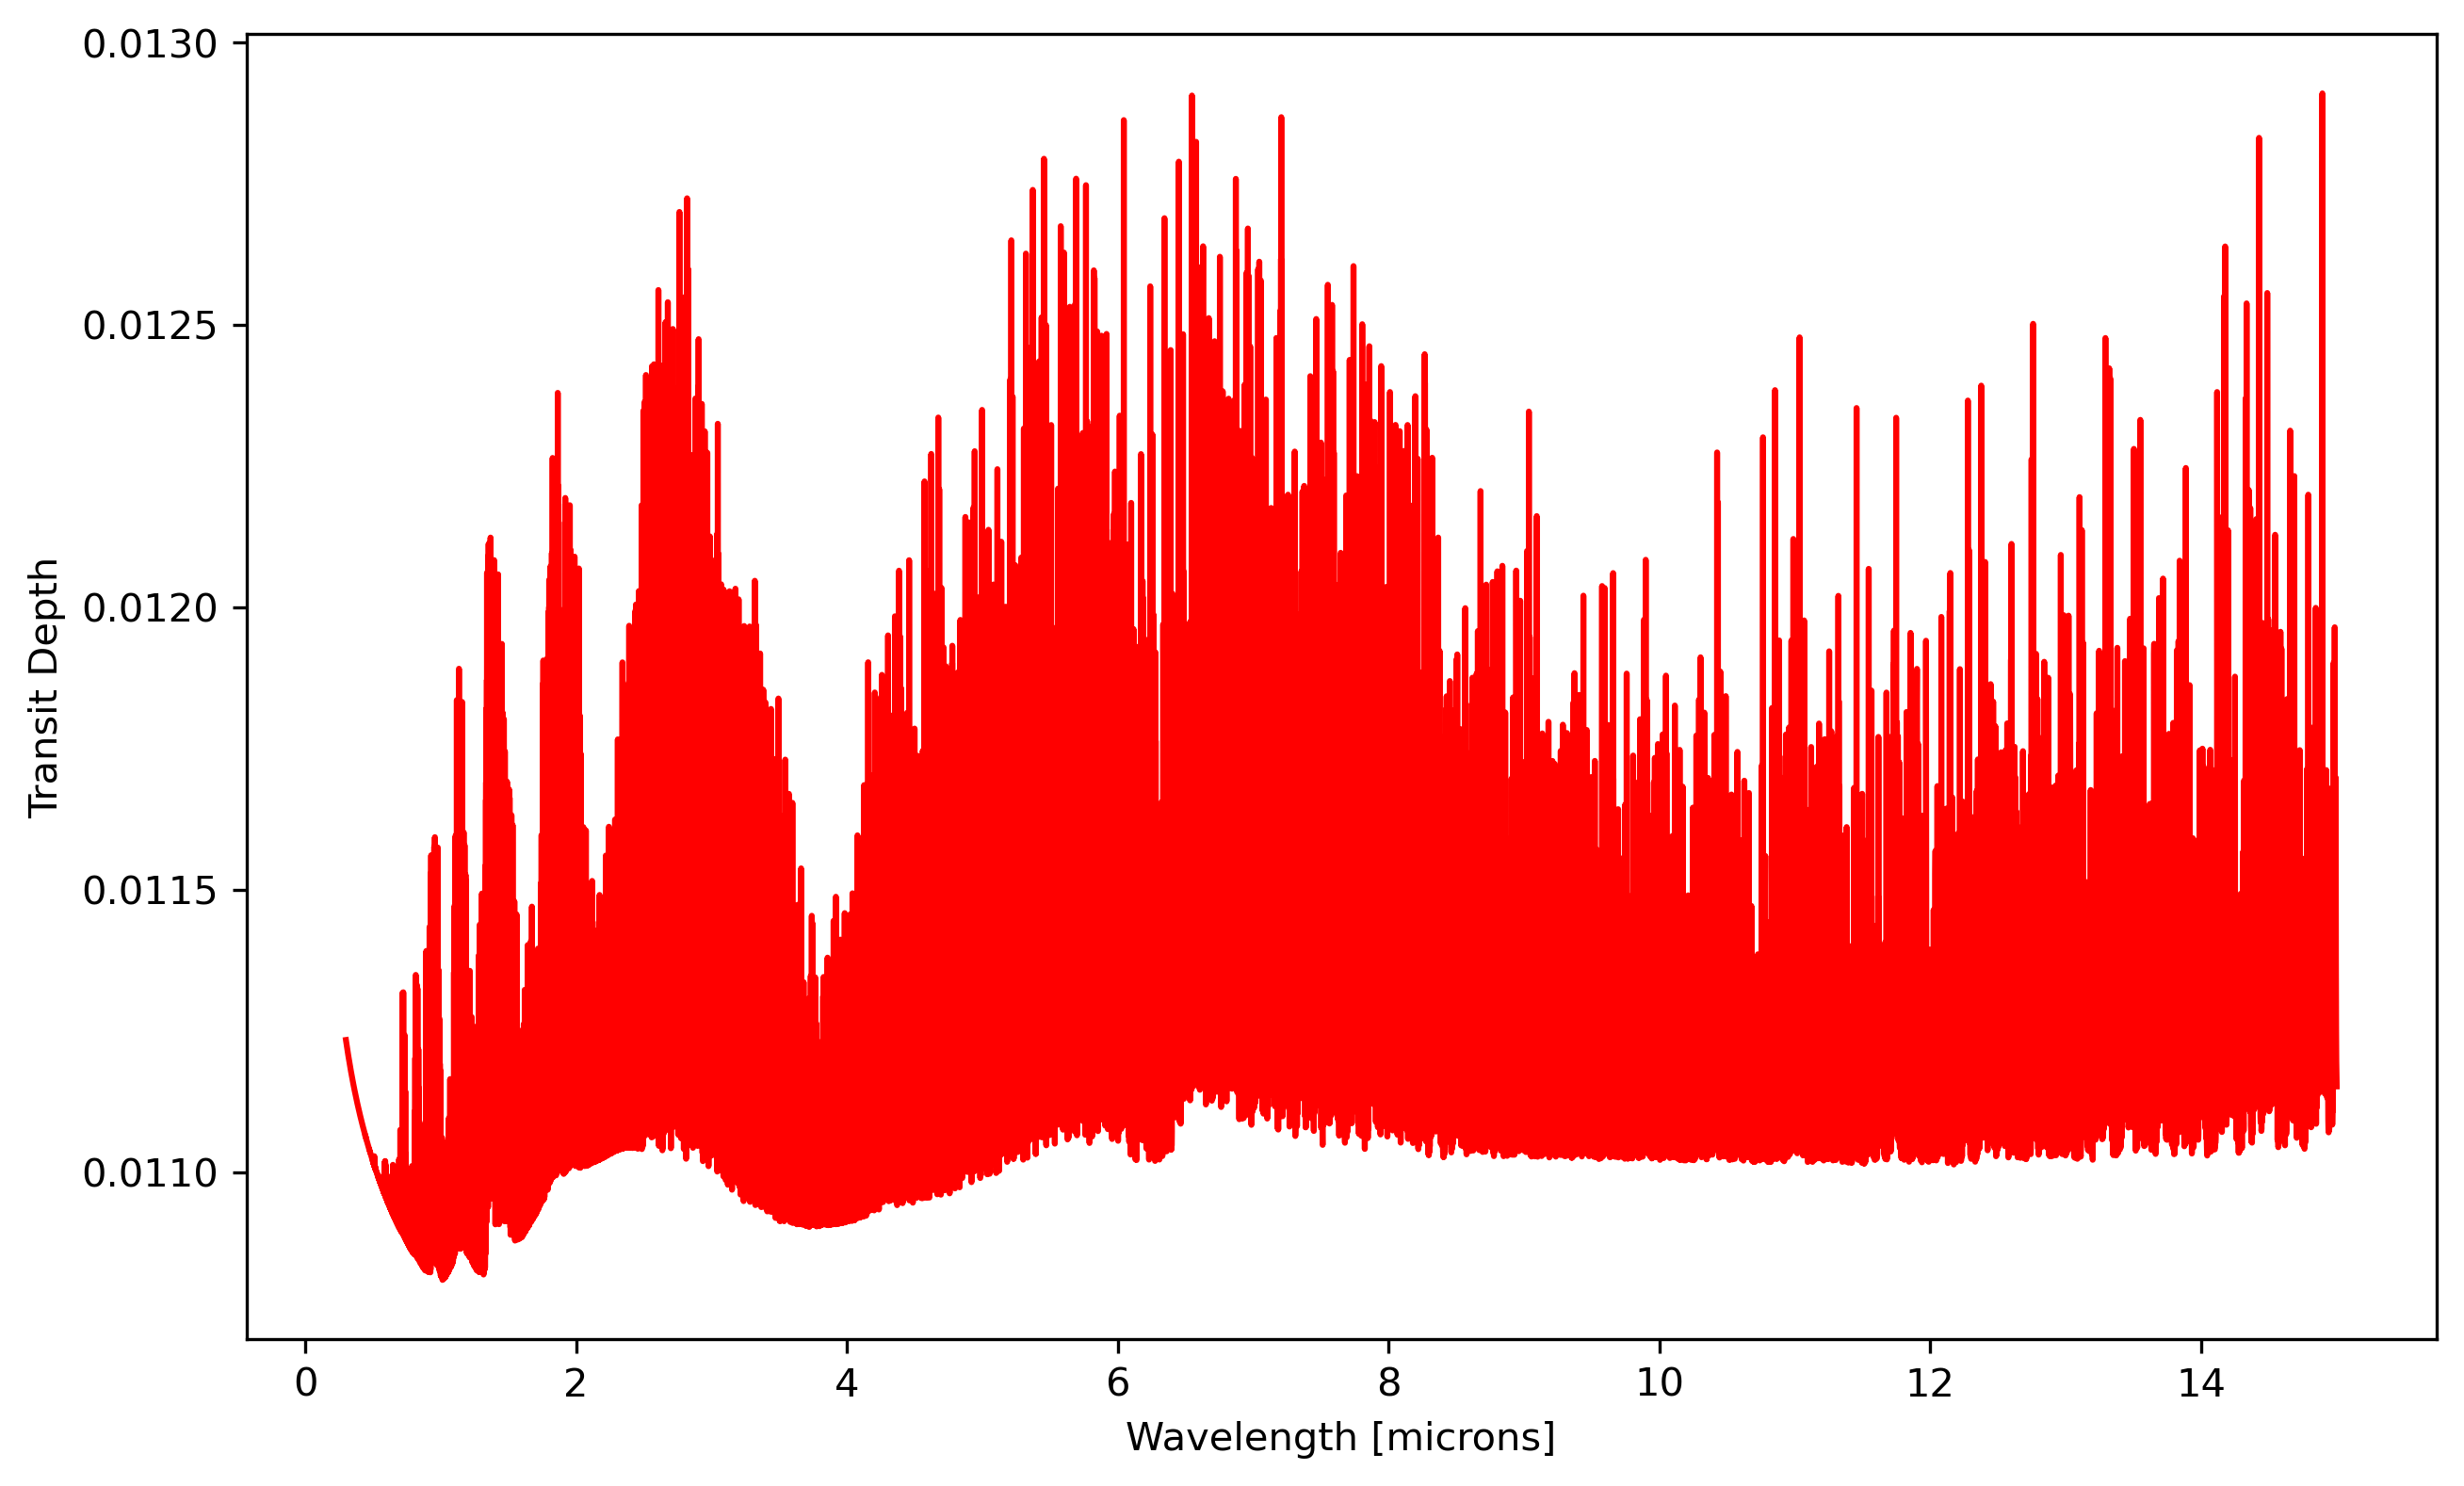

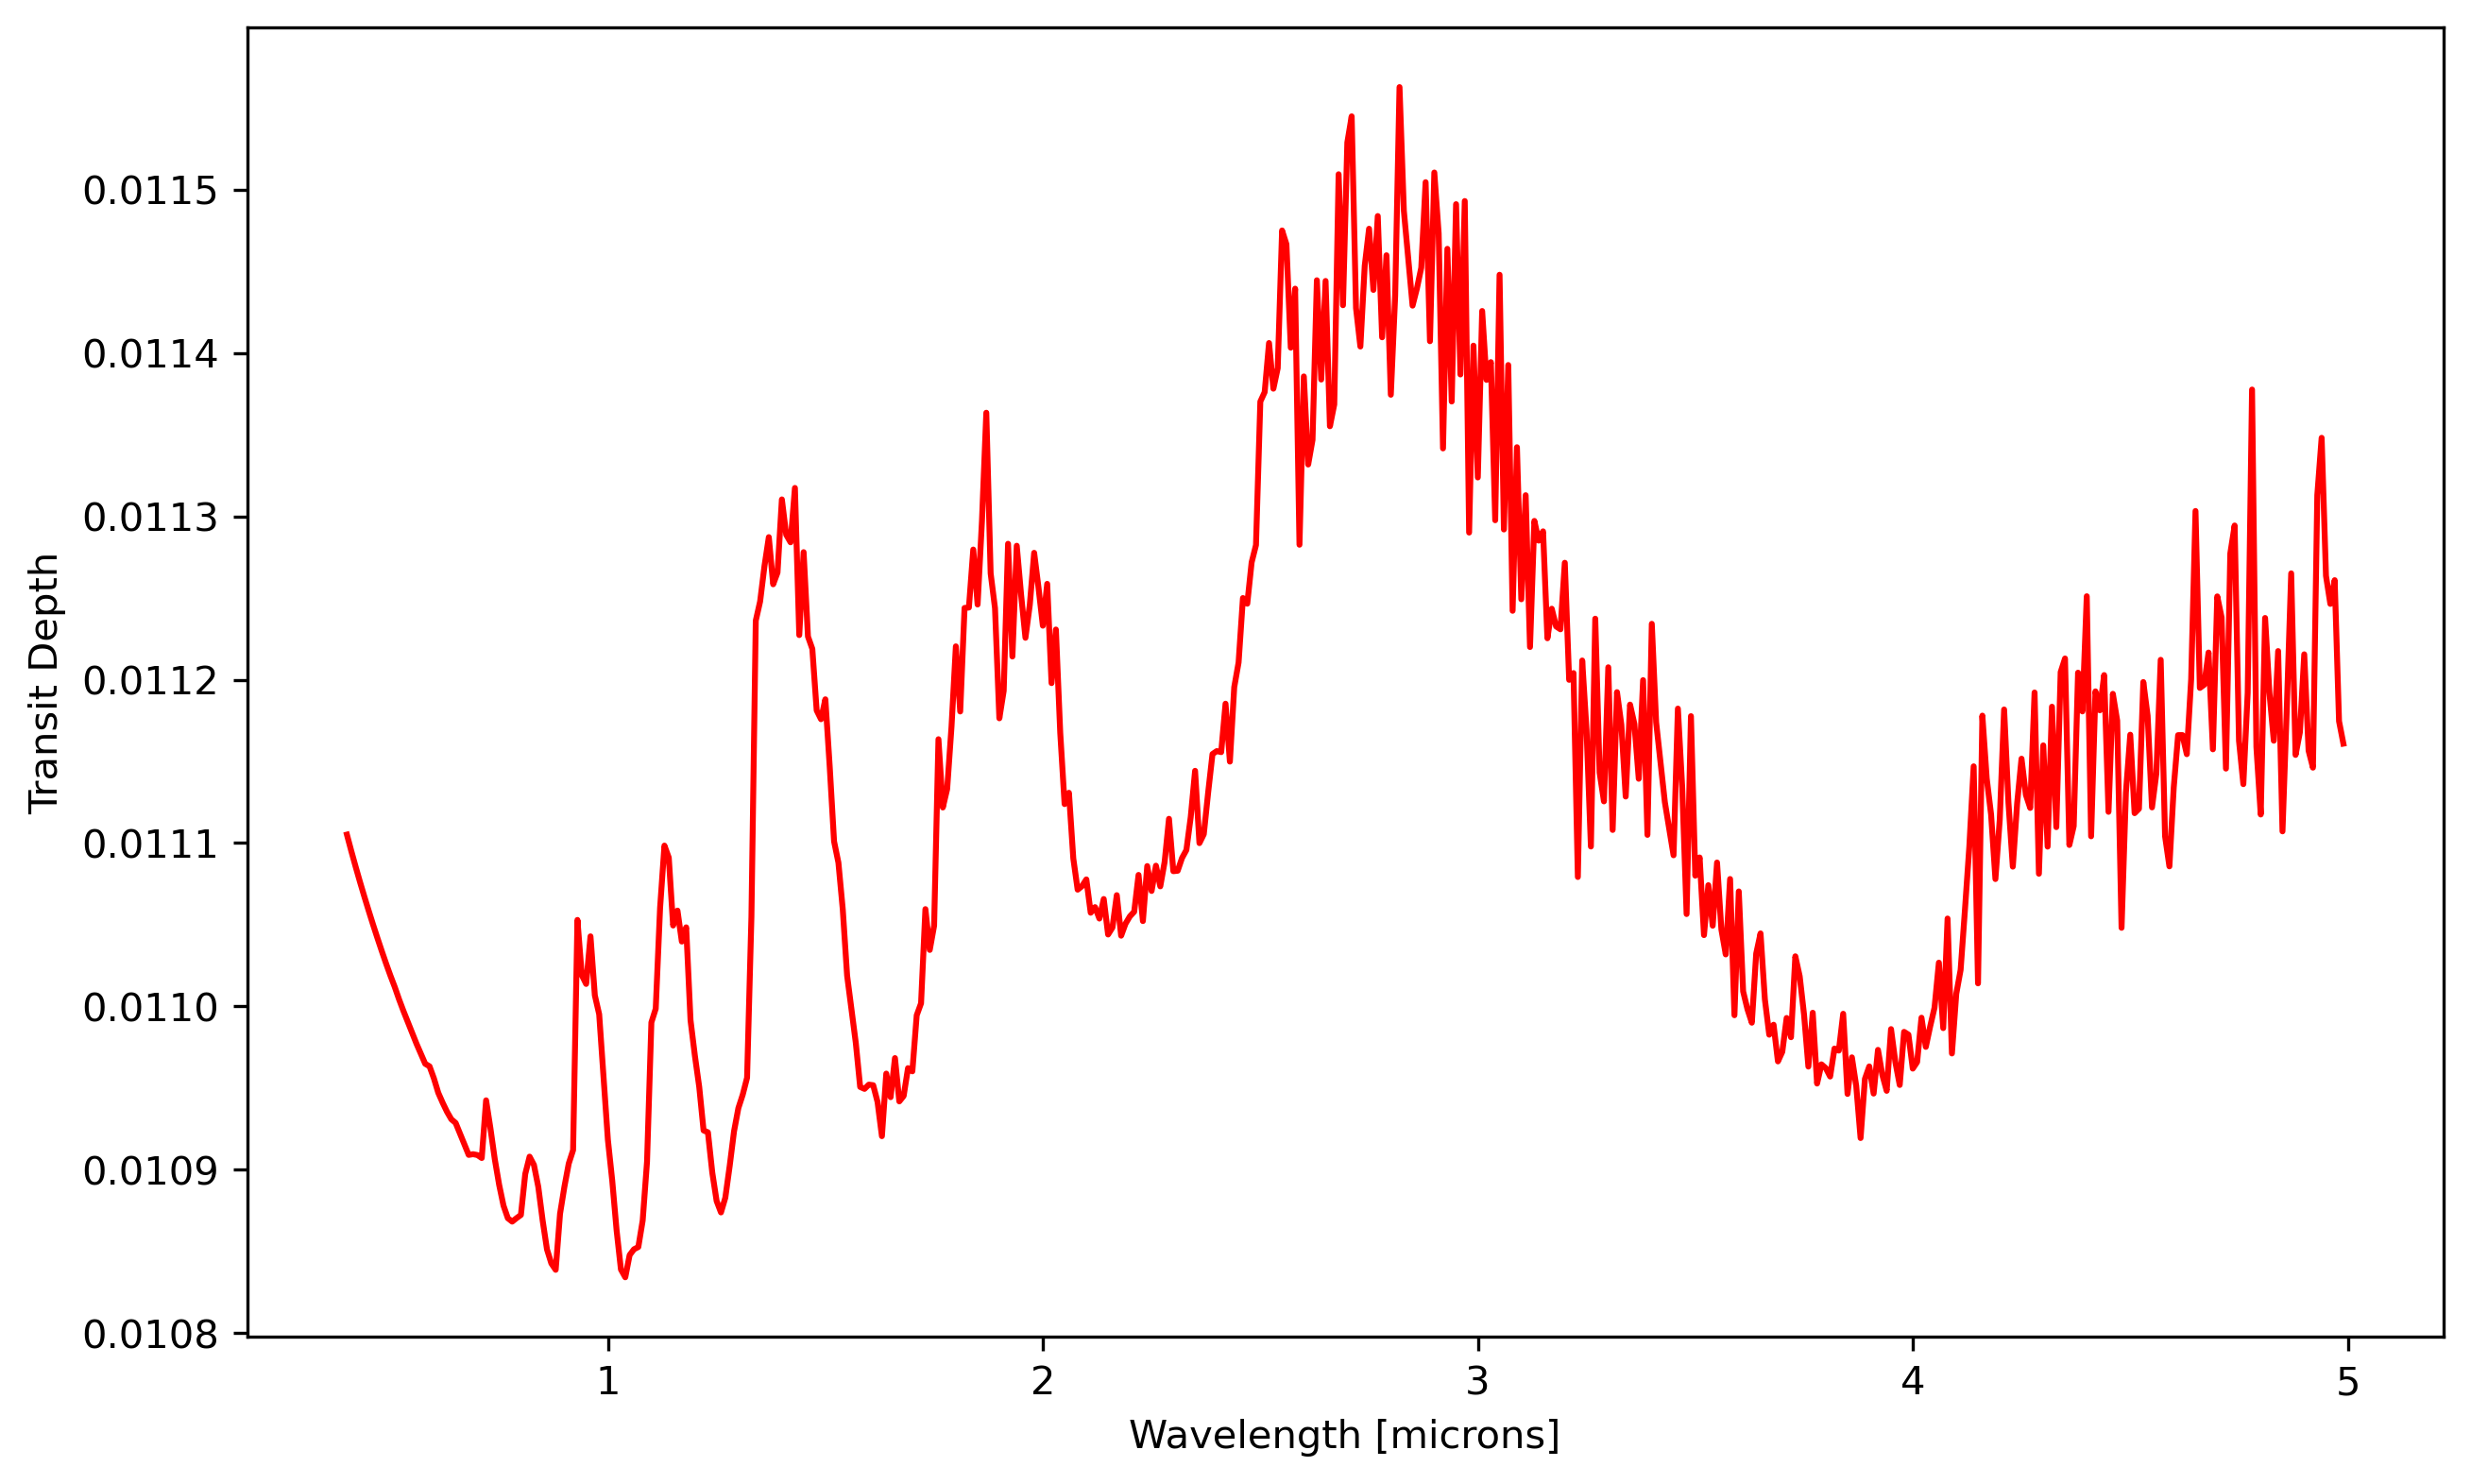

In [50]:
"""
Define a dictionary with some of the planet/star properties in
"""

pl_dic = {'target_data': {}}
pl_dic['target_data']['planet_radius_jup'] = 1
pl_dic['target_data']['planet_mass_jup'] = 0.5
pl_dic['target_data']['planet_temperature'] = 1000
pl_dic['target_data']['star_temperature'] = 5800
pl_dic['target_data']['star_radius'] = 1
pl_dic['target_data']['star_mass'] = 1

pl_dic['molecules'] = ['H2O']  #list of input molecules
pl_dic['abundances'] = [1e-4]  #list of volume mixing ratios for these
pl_dic['clouds'] = False  #let's ignore these for now

hr_spec = create_spec(pl_dic)

plt.figure(figsize=(10, 6))
plt.plot(hr_spec['wavelength'], hr_spec['depth'], c='r')
plt.xlabel('Wavelength [microns]')
plt.ylabel('Transit Depth')
plt.show()

#let's bin down the hr spec to something more managable...

bd = 0.01
lr_spec = pd.DataFrame(np.arange(0.4, 5, bd), columns=['wavelength'])
lr_spec['bandwidth'] = bd
lr_spec['depth'] = bin_spectrum(lr_spec.copy(), hr_spec)

plt.figure(figsize=(10, 6))
plt.plot(lr_spec['wavelength'], lr_spec['depth'], c='r')
plt.xlabel('Wavelength [microns]')
plt.ylabel('Transit Depth')
plt.show()

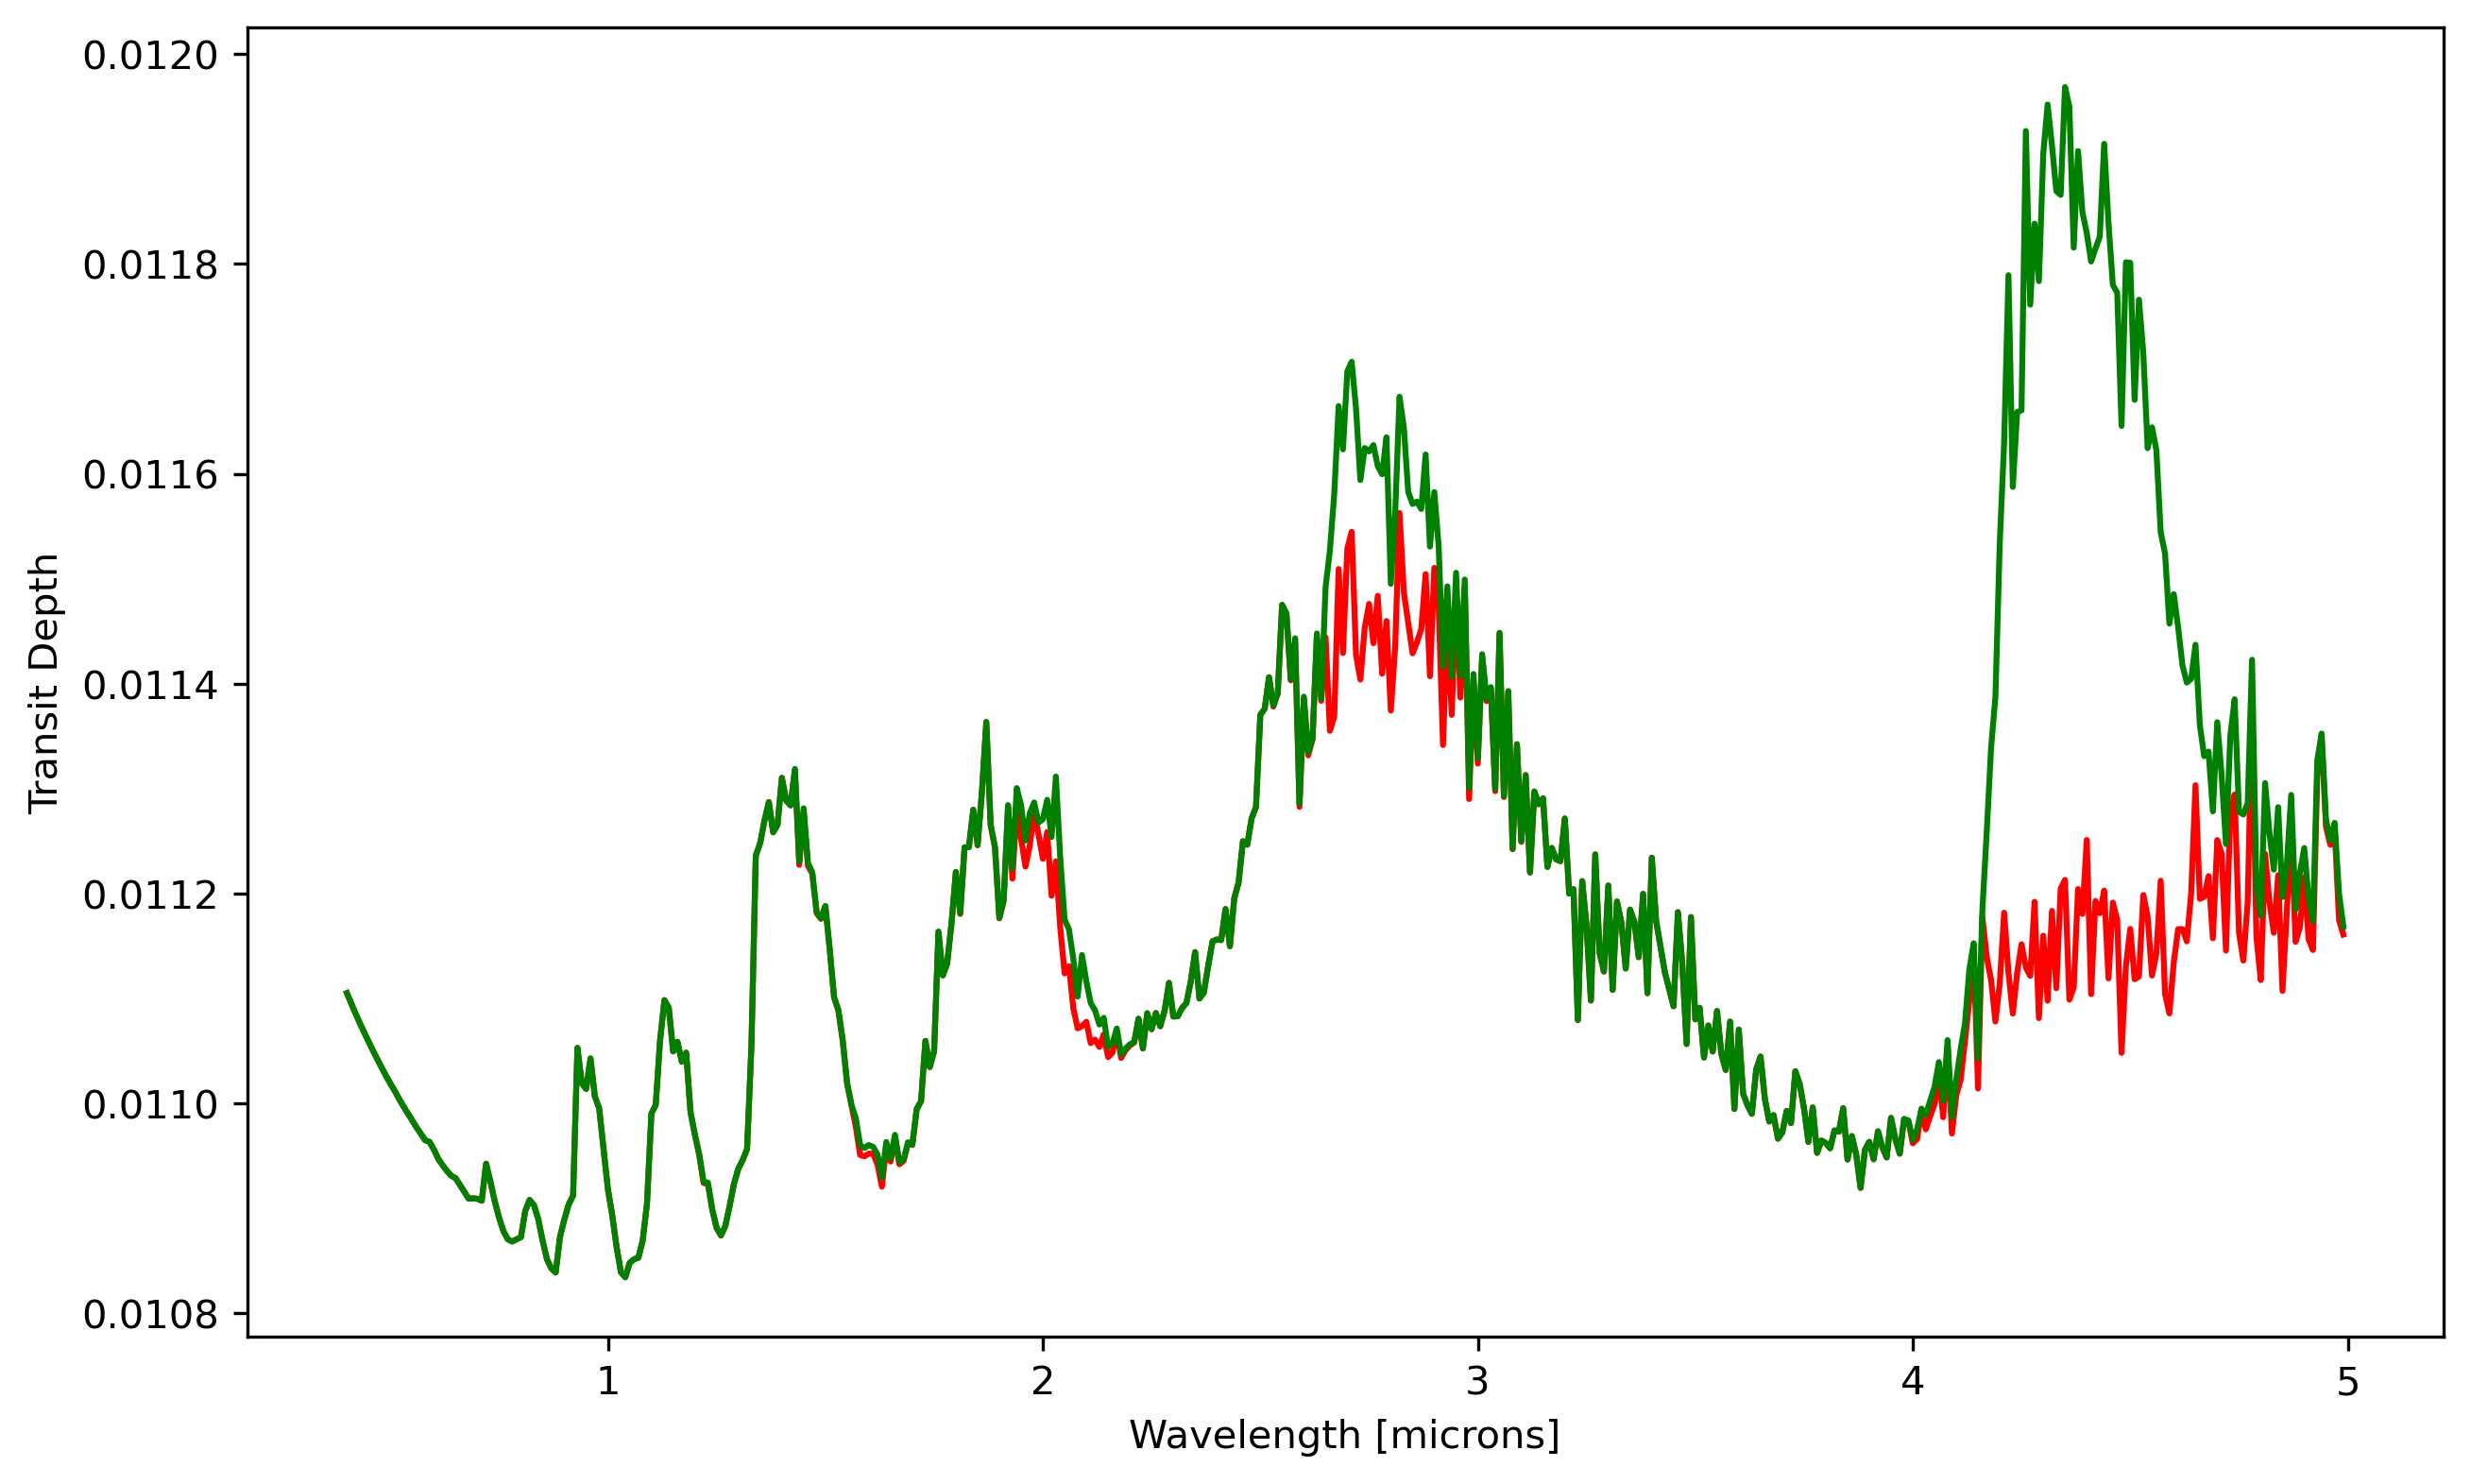

In [51]:
#add another molecule...
pl_dic['molecules'] = ['H2O', 'CO2']  #list of input molecules
pl_dic['abundances'] = [1e-4, 1e-5]  #list of volume mixing ratios for these
pl_dic['clouds'] = False  #let's ignore these for now

hr_spec2 = create_spec(pl_dic)

lr_spec['depth2'] = bin_spectrum(lr_spec.copy(), hr_spec2)

plt.figure(figsize=(10, 6))
plt.plot(lr_spec['wavelength'], lr_spec['depth'], c='r')
plt.plot(lr_spec['wavelength'], lr_spec['depth2'], c='g')
plt.xlabel('Wavelength [microns]')
plt.ylabel('Transit Depth')
plt.show()